# Signal Processing

## Oscillator

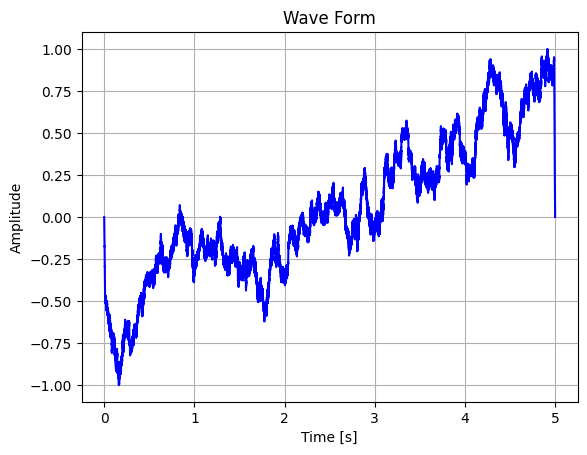

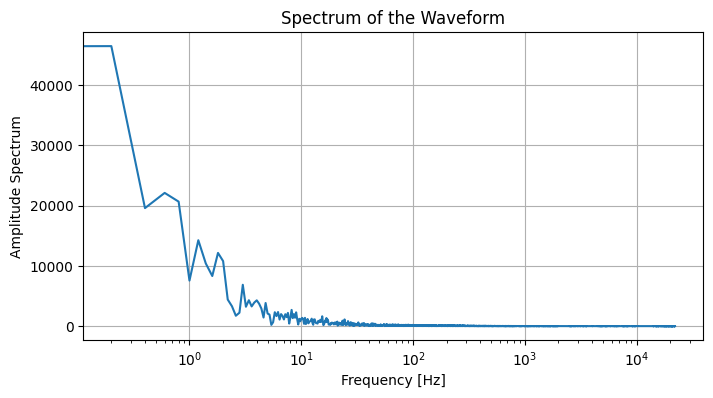

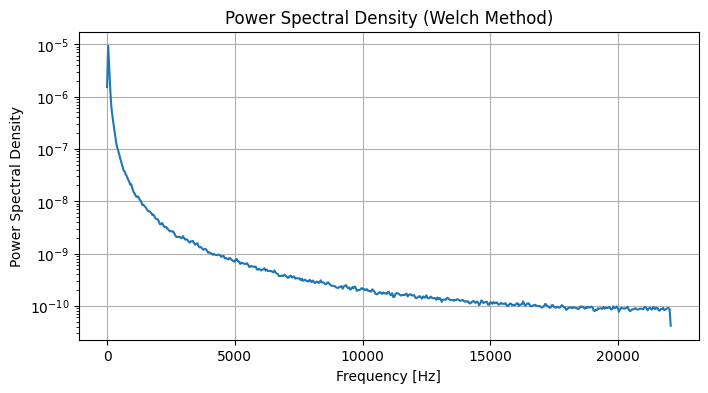

データの型: float64
データの形状: (220500,)


In [15]:
from enum import Enum
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import sounddevice as sd

SAMPLE_RATE = 44100  # Hz

def gent(dur_sec, sample_rate):
    return np.linspace(0, dur_sec, int(dur_sec * sample_rate), endpoint=False)

def sin(t, f):
    return np.sin(2 * np.pi * f * t)

def sqr(t, f):
    return np.sign(np.sin(2 * np.pi * f * t))

def tri(t, f):
    return 2 * np.abs(2 * (t * f % 1) - 1) - 1

def saw(t, f):
    return 2 * (f * t % 1) - 1

def white_noise(t):
    return np.random.uniform(-1, 1, len(t))

def pink_noise(N):
    # Voss-McCartneyアルゴリズム
    rows = 64  # 精度を上げたい場合は増やす
    array = np.random.randn(rows, N)
    array = np.cumsum(array, axis=1)
    noise = np.sum(array, axis=0)
    noise = noise / np.max(np.abs(noise))  # 正規化
    return noise


class WaveType(Enum):
    SINE = "sine"
    SIN = "sin"
    SQUARE = "square"
    SQR = "sqr"
    TRIANGLE = "triangle"
    TRI = "tri"
    SAW = "saw"
    NOISE = "noise"

class OSC():
    def __init__(self, type, freq_input=0, oct=0, coarse=0, fine=0):
        pass

    def oscillate(self):
        pass

# ----- 時間軸の配列 -----
sample_rate = 44100  # Hz
duration = 1.0  # sec
t = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)

# ----- キホンの波形 -----
f = 440  # Hz
T = 1 / f  # sec
omega = 2 * np.pi * f  # rad / sec

# 正弦波 基音のみ
sine_wave = np.sin(2 * np.pi * f * t)

# 矩形波 全ての奇数次倍音
square_wave = np.sign(sine_wave)

# 三角波 全ての奇数次倍音，矩形波に比べて高い倍音が少ない
triangle_wave = 2 * np.abs(2 * (t * f % 1) - 1) - 1

# ノコギリ波 全ての整数次倍音
saw_wave = 2 * (f * t % 1) - 1

# ホワイトノイズ
wnoise = np.random.uniform(-1, 1, len(t))


# ----- プロットで波形を確認 ------
#%matplotlib notebook
t = gent(5, 44100)
f = 528  # おりんの周波数？
w1 = sin(t, f)
w2 = 0.5*sin(t, f+1.1)
w3 = 0.7*sin(t, f+1.5)
w4 = 0.7*sin(t, f*2)
ws = [1/f/(n+1) * sin(t, f+n) for n in np.linspace(0, 5, 8)]
wave = np.array(ws).sum(axis=0) + tri(t, f)
wave = pink_noise(len(t))
wave = 2 * (wave - np.min(wave)) / (np.max(wave) - np.min(wave)) - 1

# フェードイン・フェードアウトの適用
# フェード時間の指定（秒）
fade_duration = 0.01  # 10ミリ秒
# フェードイン・フェードアウトのサンプル数を計算
fade_samples = int(fade_duration * sample_rate)
# フェードイン用の係数を生成
# 開始からfade_samplesまでの振幅を0から1へ線形に増加
fade_in = np.linspace(0, 1, fade_samples)
# フェードアウト用の係数を生成
# 終わりからfade_samplesまでの振幅を1から0へ線形に減少
fade_out = np.linspace(1, 0, fade_samples)
# 波形にフェードイン・フェードアウトを適用
wave[:fade_samples] *= fade_in
wave[-fade_samples:] *= fade_out

# wave form
plt.plot(t[:], wave[:], color='b')
plt.title('Wave Form')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# spec
fft = np.fft.fft(wave)
freqs = np.fft.fftfreq(len(fft), 1/sample_rate)
# 片側スペクトルだけ取り出し
half = len(fft)//2
plt.figure(figsize=(8,4))
plt.plot(freqs[:half], np.abs(fft[:half]))
plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude Spectrum")
plt.title("Spectrum of the Waveform")
plt.grid()
plt.show()

# psd
f, Pxx = sig.welch(wave, fs=sample_rate, nperseg=1024)
plt.figure(figsize=(8,4))
plt.semilogy(f, Pxx)  # 対数表示にすると見やすい
#plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density (Welch Method)")
plt.grid()
plt.show()

print(f"データの型: {wave.dtype}")
print(f"データの形状: {wave.shape}")

# ----- 再生 -----
sd.play(wave, sample_rate)
sd.wait()

## Filter

## Envelope Generator

In [69]:
def EG_ADSR(t, sample_rate, attack=0.1, decay=0.2, sustain=0.7, release=0.5):
    env = np.zeros_like(t)
    N = len(t)
    A = int(attack * sample_rate)
    D = int(decay * sample_rate)
    R = int(release * sample_rate)
    S = N - (A + D + R)

    if A > 0:
        env[:A] = np.linspace(0, 1, A)
    if D > 0:
        env[A:A+D] = np.linspace(1, sustain, D)
    if S > 0:
        env[A+D:A+D+S] = sustain
    if R > 0:
        env[A+D+S:] = np.linspace(sustain, 0, R)
    return env

t = gent(0.3, 44100)
osc = OSC(t, 440)
wav = white_noise(t)
env = EG_ADSR(t, sample_rate, 0.01, 0.14, 0, 0.0)
wav *= env  # ==== 3. AMP ====

plt.plot(t[::], wav[::], color='b')
#plt.plot(t[:2000], saw_wave[:2000], color='r')
plt.title('Wave Form')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# ==== 4. 出力 ====
sd.play(wav, sample_rate)
sd.wait()


<IPython.core.display.Javascript object>